In [67]:
import numpy as np
import torch
from torch.autograd import Variable
from torchvision import transforms, datasets
import torchvision.models.vgg as vgg
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from torchsummary import summary
import time
import glob
import importlib



import data
importlib.reload(data)
import loss_network
importlib.reload(loss_network)
import transformer_network
importlib.reload(transformer_network)

<module 'transformer_network' from 'c:\\Users\\kobil\\Documents\\CSC2503\\Final_Proj\\transformer_network.py'>

In [68]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

CUDA = torch.cuda.is_available()

if CUDA:
    device = torch.device("cuda")
    torch.cuda.manual_seed(SEED)
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device = torch.device("cpu")
    torch.set_default_tensor_type('torch.FloatTensor')


In [69]:
IMAGE_SIZE = 224
BATCH_SIZE = 4
DATASET_PATH = 'C:\\Users\\kobil\\Documents\\CSC2503\\Final_Proj\\data\\coco_2017'

train_ds = data.get_dataset(DATASET_PATH, IMAGE_SIZE)
train_dl = data.get_dataloader(train_ds, BATCH_SIZE)

In [70]:
loss_net = loss_network.LossNetwork()
loss_net.to(device)

summary(loss_net,(3,IMAGE_SIZE,IMAGE_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1                          []                        --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        36,928
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       73,856
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       147,584
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         295,168
|    └─ReLU: 2-12                        [-1, 256, 56, 56]      

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1                          []                        --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        36,928
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       73,856
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       147,584
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         295,168
|    └─ReLU: 2-12                        [-1, 256, 56, 56]      

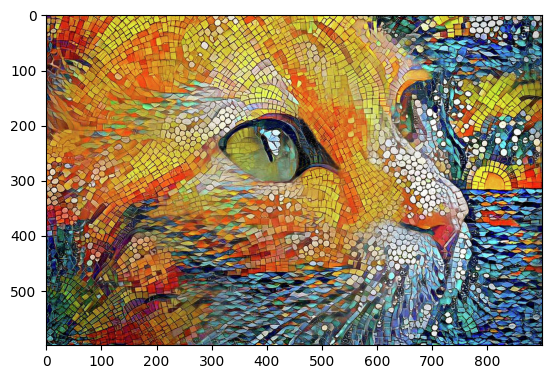

In [71]:
style_img = Image.open('./data/style_images/ginger_cat.jpg').convert('RGB')
plt.imshow(style_img)

In [72]:
with torch.no_grad():
    style_img_tensor = transforms.Compose([
        transforms.Resize(IMAGE_SIZE* 2),
        transforms.ToTensor(),
        #transforms.Normalize((0.485, 0.456, 0.406),#COCO Mean
                            #(0.229, 0.224, 0.225))] #COCO STD
    ])(style_img).unsqueeze(0)

    style_img_tensor = style_img_tensor.to(device)


In [73]:
def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram

In [74]:
with torch.no_grad():
    style_loss_features = loss_net(style_img_tensor)
    gram_style = [gram_matrix(y) for y in style_loss_features]

In [75]:
style_loss_features._fields

('relu1', 'relu2', 'relu3', 'relu4', 'relu5')

In [76]:
transformer = transformer_network.TransformerNet()
mse_loss = torch.nn.MSELoss()
transformer.to(device)

TransformerNet(
  (conv1): ConvLayer(
    (reflection_pad): ReflectionPad2d((4, 4, 4, 4))
    (conv2d): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1))
  )
  (in1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv2): ConvLayer(
    (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
    (conv2d): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  )
  (in2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv3): ConvLayer(
    (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
    (conv2d): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  )
  (in3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (res1): ResidualBlock(
    (conv1): ConvLayer(
      (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
      (conv2d): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    )
    (in1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (

In [77]:
torch.set_default_tensor_type('torch.FloatTensor')
    
def train(steps, base_steps=0):
    transformer.train()
    count = 0
    agg_content_loss = 0.
    agg_style_loss = 0.
    agg_reg_loss = 0.   
    while True:
        for x, _ in train_dl:
            count += 1
            optimizer.zero_grad()
            x = x.to(device)             
            y = transformer(x)            
                        
            with torch.no_grad():
                xc = x.detach()

            features_y = loss_net(y)
            features_xc = loss_net(xc)

            with torch.no_grad():
                f_xc_c = features_xc[2].detach()

            content_loss = CONTENT_WEIGHT * mse_loss(features_y[2], f_xc_c)

            reg_loss = REGULARIZATION * (
                torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) + 
                torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :])))

            style_loss = 0.
            for l, weight in enumerate(STYLE_WEIGHTS):
                gram_s = gram_style[l]
                gram_y = gram_matrix(features_y[l])
                style_loss += float(weight) * mse_loss(gram_y, gram_s.expand_as(gram_y))
                
            total_loss = content_loss + style_loss + reg_loss 
            total_loss.backward()
            optimizer.step()

            agg_content_loss += content_loss
            agg_style_loss += style_loss
            agg_reg_loss += reg_loss

            if count % LOG_INTERVAL == 0:
                mesg = "{} [{}/{}] content: {:.2f}  style: {:.2f}  reg: {:.2f} total: {:.6f}".format(
                            time.ctime(), count, steps,
                            agg_content_loss / LOG_INTERVAL,
                            agg_style_loss / LOG_INTERVAL,
                            agg_reg_loss / LOG_INTERVAL,
                            (agg_content_loss + agg_style_loss + 
                             agg_reg_loss ) / LOG_INTERVAL
                        )
                print(mesg)
                agg_content_loss = 0.
                agg_style_loss = 0.
                agg_reg_loss = 0.
                agg_stable_loss = 0.
                transformer.eval()
                y = transformer(x)
                transformer.train()
                
            if count >= steps:
                return

In [78]:

CONTENT_WEIGHT = 1
STYLE_WEIGHTS = np.array([1e-1, 1, 1e1, 5, 1e1]) * 1e5
REGULARIZATION = 1e-6
LOG_INTERVAL = 50

LR = 1e-3
optimizer = torch.optim.Adam(transformer.parameters(), LR)

In [79]:
len(train_dl)

29572

In [80]:
train(1000, 0)

Fri Apr  7 14:15:47 2023 [50/1000] content: 20.78  style: 67.06  reg: 0.10 total: 87.943878
Fri Apr  7 14:16:01 2023 [100/1000] content: 22.29  style: 14.28  reg: 0.10 total: 36.671631
Fri Apr  7 14:16:15 2023 [150/1000] content: 21.43  style: 10.46  reg: 0.10 total: 31.995649
Fri Apr  7 14:16:30 2023 [200/1000] content: 21.13  style: 8.79  reg: 0.11 total: 30.032055
Fri Apr  7 14:16:44 2023 [250/1000] content: 21.56  style: 8.28  reg: 0.12 total: 29.959024
Fri Apr  7 14:16:59 2023 [300/1000] content: 21.52  style: 7.01  reg: 0.13 total: 28.655046
Fri Apr  7 14:17:14 2023 [350/1000] content: 22.01  style: 5.88  reg: 0.13 total: 28.017395
Fri Apr  7 14:17:29 2023 [400/1000] content: 21.62  style: 5.01  reg: 0.13 total: 26.759777
Fri Apr  7 14:17:44 2023 [450/1000] content: 21.46  style: 5.14  reg: 0.13 total: 26.730553
Fri Apr  7 14:17:59 2023 [500/1000] content: 21.93  style: 4.45  reg: 0.13 total: 26.508196
Fri Apr  7 14:18:13 2023 [550/1000] content: 21.70  style: 4.28  reg: 0.13 tot

In [81]:
optimizer = torch.optim.Adam(transformer.parameters(), LR * 0.5)
train(3000, 1000)

Fri Apr  7 14:20:47 2023 [50/3000] content: 20.50  style: 4.80  reg: 0.13 total: 25.428495
Fri Apr  7 14:21:01 2023 [100/3000] content: 19.73  style: 3.62  reg: 0.13 total: 23.477741
Fri Apr  7 14:21:16 2023 [150/3000] content: 20.08  style: 3.66  reg: 0.13 total: 23.878191
Fri Apr  7 14:21:30 2023 [200/3000] content: 19.59  style: 3.42  reg: 0.13 total: 23.138515
Fri Apr  7 14:21:45 2023 [250/3000] content: 19.28  style: 3.54  reg: 0.13 total: 22.948530
Fri Apr  7 14:21:59 2023 [300/3000] content: 19.90  style: 3.53  reg: 0.13 total: 23.560520
Fri Apr  7 14:22:13 2023 [350/3000] content: 19.22  style: 3.61  reg: 0.13 total: 22.954626
Fri Apr  7 14:22:28 2023 [400/3000] content: 18.91  style: 3.40  reg: 0.13 total: 22.436960
Fri Apr  7 14:22:42 2023 [450/3000] content: 18.53  style: 3.32  reg: 0.13 total: 21.977365
Fri Apr  7 14:22:57 2023 [500/3000] content: 19.53  style: 3.43  reg: 0.13 total: 23.094084
Fri Apr  7 14:23:11 2023 [550/3000] content: 18.70  style: 3.47  reg: 0.13 total:

In [82]:
save_model_path = "models/picaso_4000_unstable_vgg19.pth"
torch.save(transformer.state_dict(), save_model_path)

In [83]:

#LOG_INTERVAL = 100
#optimizer = torch.optim.Adam(transformer.parameters(), LR * 0.1)
#train(6000, 4000)

In [84]:
#save_model_path = "models/picaso_10000_unstable_vgg19.pth"
#torch.save(transformer.state_dict(), save_model_path)

In [85]:
fnames = glob.glob(DATASET_PATH + r"/*/*")
len(fnames)

118287

In [86]:
transformer = transformer.eval()

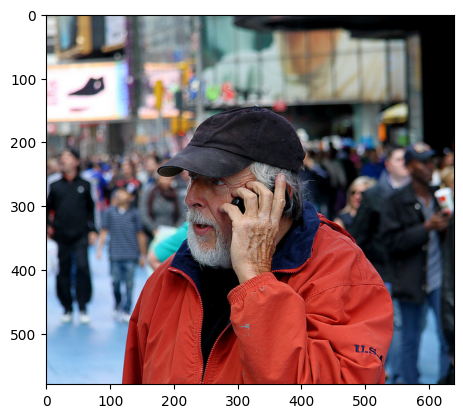

In [139]:
img = Image.open(fnames[70]).convert('RGB')
plt.imshow(img)
img_tensor = transforms.Compose([
        transforms.Resize(IMAGE_SIZE* 2),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),#COCO Mean
                            (0.229, 0.224, 0.225))] #COCO STD]
    )(img).unsqueeze(0)
img_tensor = img_tensor.cuda()


In [140]:
def recover_image(img):
    return (
        (
            img *
            np.array([0.229, 0.224, 0.225]).reshape((1, 3, 1, 1)) +
            np.array([0.485, 0.456, 0.406]).reshape((1, 3, 1, 1))
        ).transpose(0, 2, 3, 1) *
        255.
    ).clip(0, 255).astype(np.uint8)

In [141]:

img_output = transformer(img_tensor)

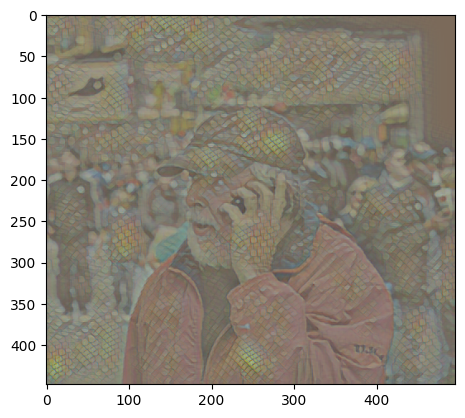

In [142]:
img_output = img_output.cpu()
img_output = img_output.detach().numpy()
#img_output = np.reshape(img_output, (3,448,448))
#img_output = img_output * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
#img_output = np.transpose(img_output, (1,2,0))
img_output = recover_image(img_output)
img_output = np.reshape(img_output, (448, 496, 3))
plt.imshow(img_output)